# Introduction to Regularization

In [1]:
#!pip install ipywidgets IPython

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Learning Objectives

1. Describe what a loss function is.
2. Define regularization.
3. Describe and differentiate LASSO and Ridge regularization.
4. Understand how regularization affects the bias-variance tradeoff.
5. Implement LASSO regression and Ridge regression.

## Review

<details><summary>What is the bias-variance tradeoff?</summary>

- Mean squared error can be decomposed into a bias component plus a variance component (plus a systematic error, but we don't have control over this part, so we often ignore it).
- The bias-variance tradeoff refers to the fact that taking steps to minimize bias usually comes at the expense of an increase in variance. Similarly, taking steps to minimize variance usually comes at the expense of an increase in bias.

</details>

---

<details><summary>What evidence/information would lead me to believe that my model suffers from high variance?</summary>
    
- After splitting my data into training and testing sets, if I see that my model performs way better on my training set than my testing set, this means that my model is not generalizing very well to "new" data.
- An example might be where our training MSE is substantially lower than our testing MSE, or where our training R-squared is substantially higher than our testing R-squared.
</details>

---

<details><summary>What term do we use to describe a model that suffers from high variance?</summary>

- Overfit.
</details>

## Why is high variance bad?

High variance is bad because it means that our model doesn't generalize well to new data. This means that our model looks as though it performs well on our training data but won't perform as well on new, unseen data.

---
<details><summary>How might we try to fix a model that suffers from high variance?</summary>

- Gather more data. (Although this is usually expensive and time-consuming.)
- Drop features.
- Make our existing features less complex. (i.e. get rid of interaction terms or higher order terms.)
- Choose a simpler model.
- Regularization!
</details>

## Overview of regularization

---

"Regularizing" regression models is to:
- **automatically** avoid overfitting 
- while we fit our model
- by adding a "penalty" to our loss function.

Remember what our loss function has looked like so far:

$$
\begin{eqnarray*}
\text{minimize: }SSE &=& \sum_{i=1}^n (y_i - \hat{y}_i)^2
\end{eqnarray*}
$$

In ordinary least squares (OLS) linear regression, we find the line of best fit by selecting the values of $\hat{\pmb\beta}$ that minimize the sum of squared errors (SSE).

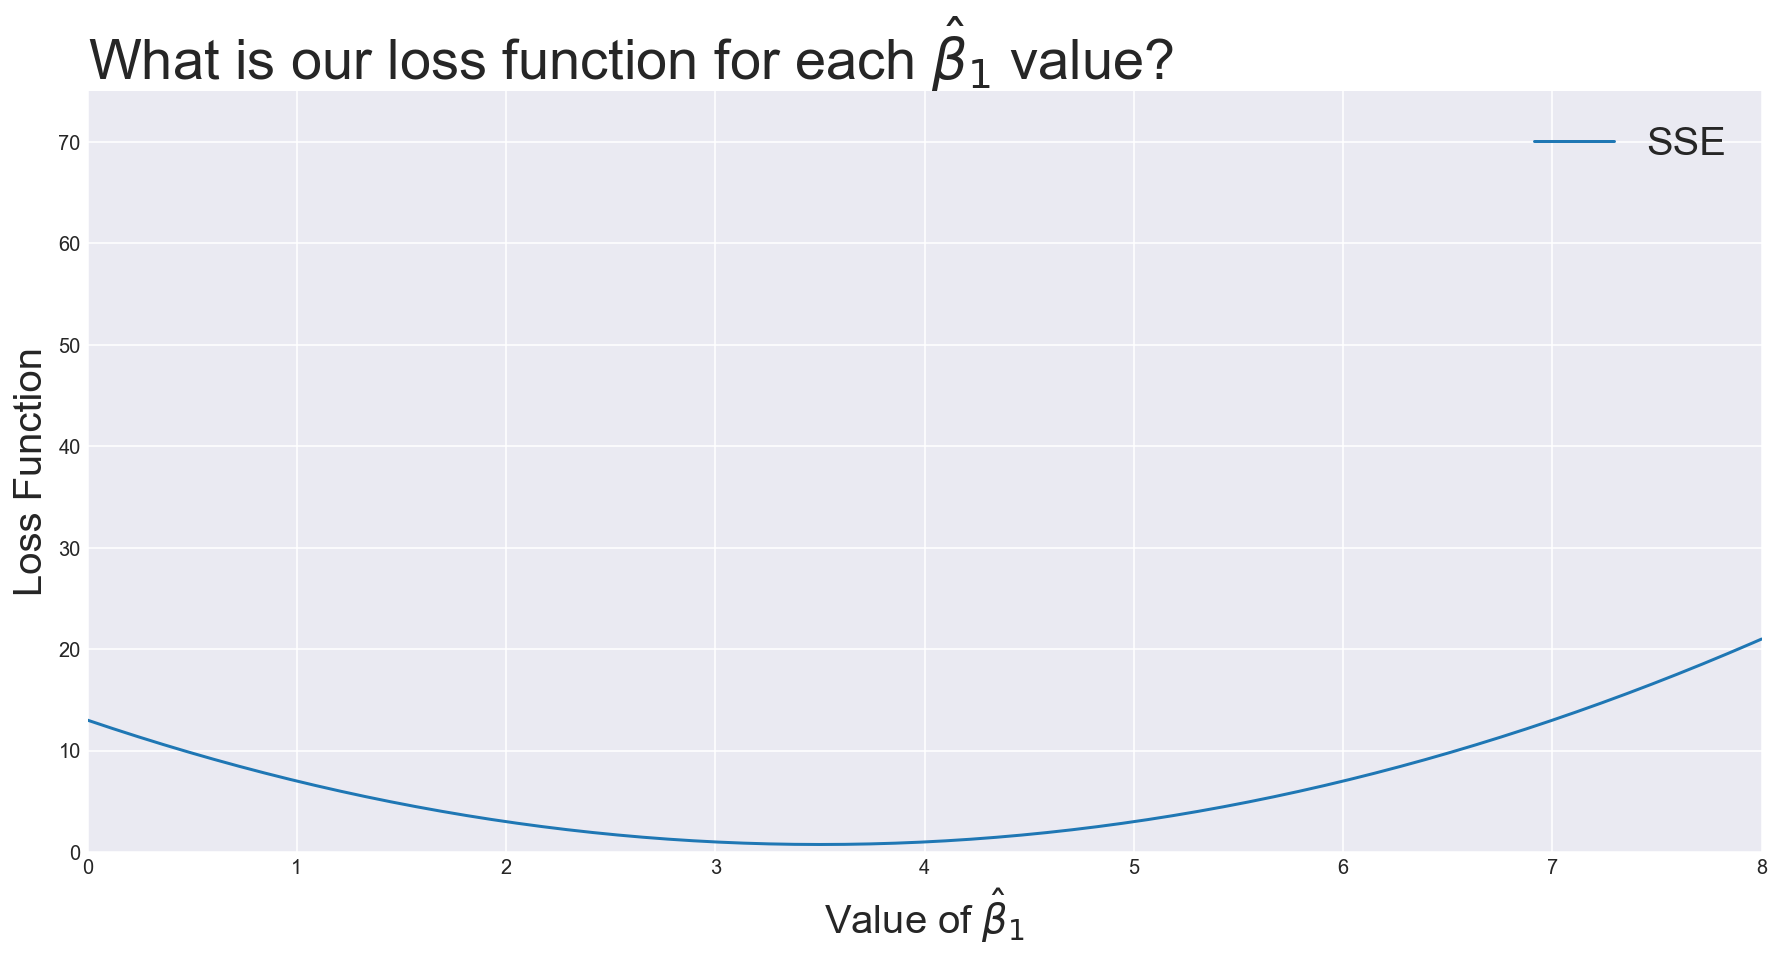

In [3]:
plt.figure(figsize=(15, 7))

beta_1 = np.linspace(0, 8, 200)

sse = beta_1 ** 2 - 7 * beta_1 + 13

plt.ylabel('Loss Function', fontsize = 20)
plt.xlabel(r'Value of $\hat{\beta}_1$', fontsize = 20) # The r allows us to typeset with LaTeX.
plt.title(r'What is our loss function for each $\hat{\beta}_1$ value?',
          fontsize = 28,
          x = 0,
          ha = 'left')
plt.xlim((0, 8))
plt.ylim((0, 75))

plt.plot(beta_1, sse, label = 'SSE')

plt.legend(fontsize = 20);

<details><summary>Based on the above plot, what value for beta_1 should my model select?</summary>
    
- When fitting our model, we want to minimize our loss function.
- Our loss function is minimized at 3.5.
</details>

Regularization adds an extra piece to our loss function to avoid overfitting. When fitting a regularized linear regression model, we'll minimize this **new** loss function, which is the sum of squared errors plus a penalty.

$$
\begin{eqnarray*}
\text{minimize: }SSE + \text{Ridge penalty} &=& \sum_{i=1}^n (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^p \beta_j^2
\end{eqnarray*}
$$


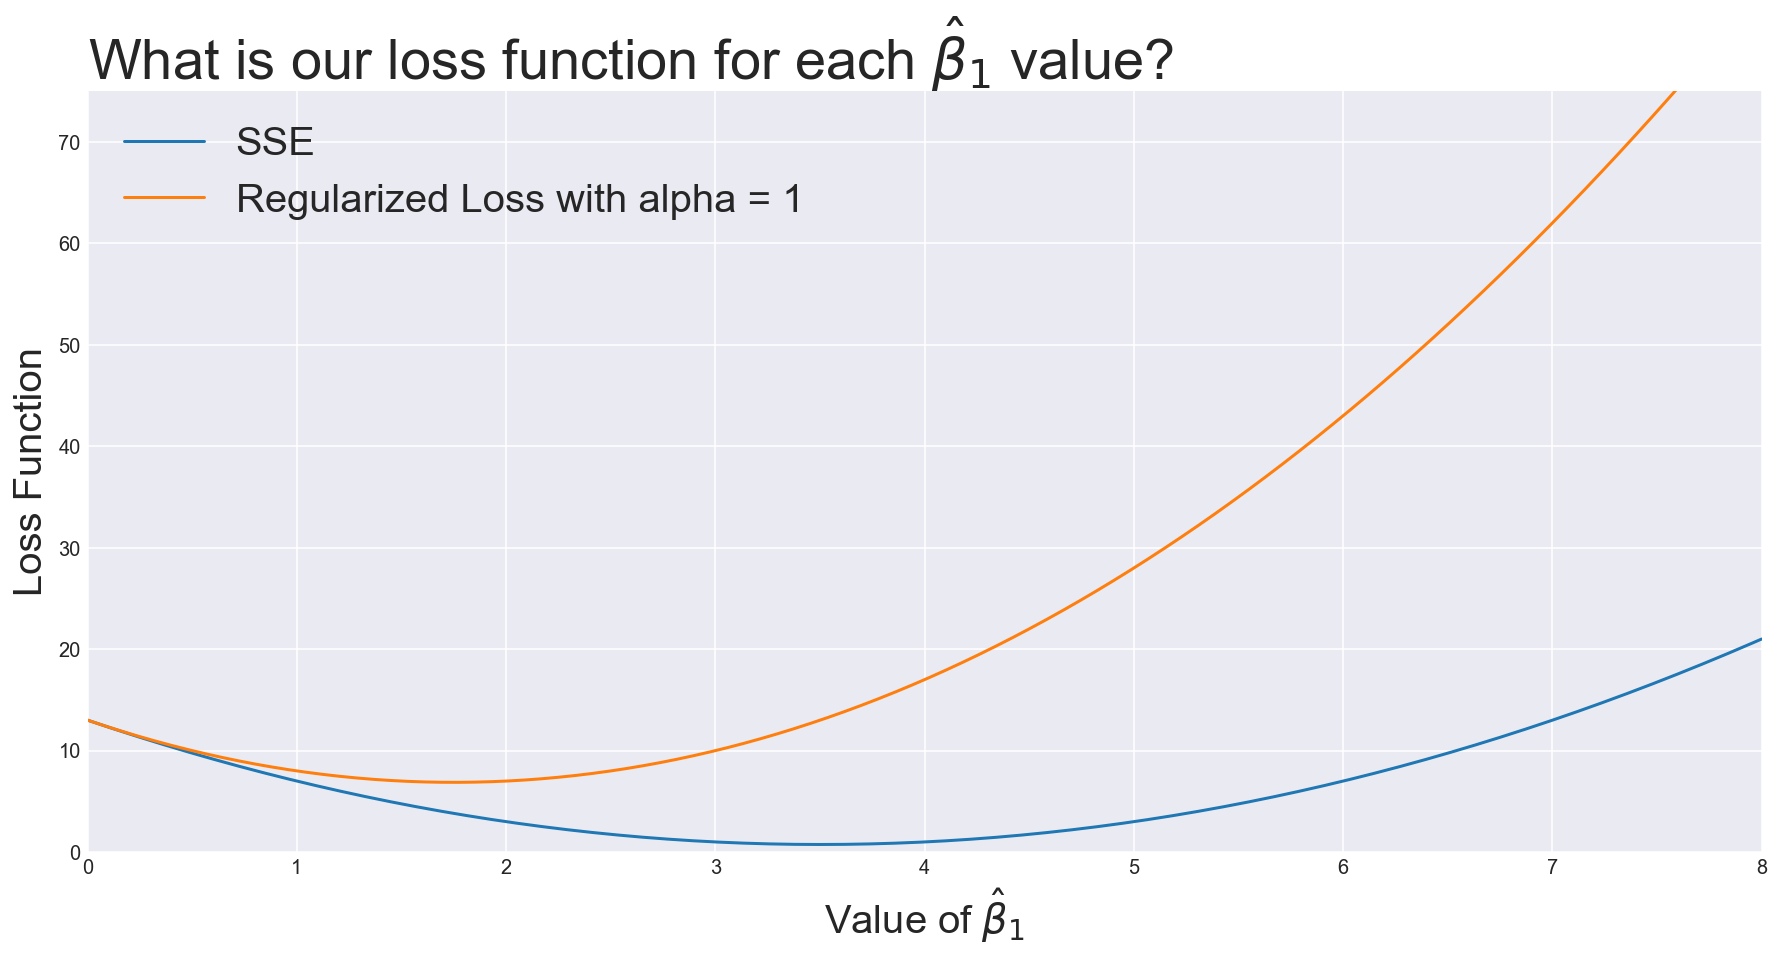

In [4]:
plt.figure(figsize=(15, 7))

beta_1 = np.linspace(0, 8, 200)

sse = beta_1 ** 2 - 7 * beta_1 + 13

alpha = 1
reg_loss = sse + alpha * beta_1 ** 2

plt.ylabel('Loss Function', fontsize = 20)
plt.xlabel(r'Value of $\hat{\beta}_1$', fontsize = 20) # The r allows us to typeset with LaTeX.
plt.title(r'What is our loss function for each $\hat{\beta}_1$ value?',
          fontsize = 28,
          x = 0,
          ha = 'left')
plt.xlim((0, 8))
plt.ylim((0, 75))

plt.plot(beta_1, sse, label = 'SSE')

plt.plot(beta_1, reg_loss, label = f'Regularized Loss with alpha = {alpha}')

plt.legend(fontsize = 20);

<details><summary>If I used my regularized loss function to fit my model, what would my value for beta_1 be?</summary>
    
- Our regularized loss function is minimized around 1.8.
</details>

#### What does this do?
This new loss function ensures the coefficients don't get too big when they shouldn't!

Put another way, this new loss function makes sure our coefficients are based on signal (the thing we want to detect/understand) and not noise (the random fluctuations in our data we want to ignore).
- If the coefficients are large because of noise, then our loss function will likely gently slope, allowing regularization to push the coefficients considerably toward zero.
- If the coefficients are large because they're supposed to be large, then our loss function will likely be steep and regularization will have little effect on the coefficients.
    - To visually check this, try using `sse = 8 * beta_1 ** 2 - 10 * beta_1 + 13` as your loss function. Look at how little of an effect regularization has on the value of beta_1!

The two most common types of regularization are the **Ridge** and **Lasso**. There is also mixture of them called the **Elastic Net**.

## What is the effect of regularization?

---

**To demonstrate the effects of regularization, we will be using a dataset on wine quality.**

### Load the wine .csv

This version has red and white wines concatenated together and tagged with a binary 1/0 indicator (1 is red wine). There are many other variables purportedly related to the rated quality of the wine.

In [5]:
wine = pd.read_csv('data/winequality_merged.csv')

wine.columns = [x.lower().replace(' ','_') for x in wine.columns]

In [6]:
# Check the first five rows.
wine.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,red_wine
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [7]:
wine.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
ph                      0
sulphates               0
alcohol                 0
quality                 0
red_wine                0
dtype: int64

An important aspect of this data is that there is **multicollinearity** in the data. The term multicollinearity means that there are _high correlations between predictor variables in your model_.

<details><summary>Based on this information, if I fit a model with this full dataset, which assumption of a multiple linear regression model would most likely be violated?</summary>

- Independence of our X variables.
</details>

**Multicollinearity can lead to a variety of problems**:
1. Small changes in your training data can result in very different model fits.
2. With very high multicollinearity, the matrix that the computer calculates may not be accurate.
    - $\hat{\pmb\beta} = (\mathbf{X}^T\mathbf{X})^{-1}(\mathbf{X}^T\mathbf{y})$ may throw an error like "Your condition number is large" or "your coefficient estimates are not stable."
3. Interpreting the coefficient of a variable that is strongly correlated with another variable is tricky.
    - **For example:** Say I want to predict income using age and years of professional experience as predictors. Attempting to interpret a one-unit increase in age might not make sense, because age and years of professional experience are probably pretty highly correlated with one another.

In [8]:
wine.corr()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,red_wine
fixed_acidity,1.000000,0.219008,0.324436,-0.111981,0.298195,-0.282735,-0.329054,0.458910,-0.252700,0.299568,-0.095452,-0.076743,0.486740
volatile_acidity,0.219008,1.000000,-0.377981,-0.196011,0.377124,-0.352557,-0.414476,0.271296,0.261454,0.225984,-0.037640,-0.265699,0.653036
citric_acid,0.324436,-0.377981,1.000000,0.142451,0.038998,0.133126,0.195242,0.096154,-0.329808,0.056197,-0.010493,0.085532,-0.187397
residual_sugar,-0.111981,-0.196011,0.142451,1.000000,-0.128940,0.402871,0.495482,0.552517,-0.267320,-0.185927,-0.359415,-0.036980,-0.348821
chlorides,0.298195,0.377124,0.038998,-0.128940,1.000000,-0.195045,-0.279630,0.362615,0.044708,0.395593,-0.256916,-0.200666,0.512678
free_sulfur_dioxide,-0.282735,-0.352557,0.133126,0.402871,-0.195045,1.000000,0.720934,0.025717,-0.145854,-0.188457,-0.179838,0.055463,-0.471644
total_sulfur_dioxide,-0.329054,-0.414476,0.195242,0.495482,-0.279630,0.720934,1.000000,0.032395,-0.238413,-0.275727,-0.265740,-0.041385,-0.700357
density,0.458910,0.271296,0.096154,0.552517,0.362615,0.025717,0.032395,1.000000,0.011686,0.259478,-0.686745,-0.305858,0.390645
ph,-0.252700,0.261454,-0.329808,-0.267320,0.044708,-0.145854,-0.238413,0.011686,1.000000,0.192123,0.121248,0.019506,0.329129
sulphates,0.299568,0.225984,0.056197,-0.185927,0.395593,-0.188457,-0.275727,0.259478,0.192123,1.000000,-0.003029,0.038485,0.487218


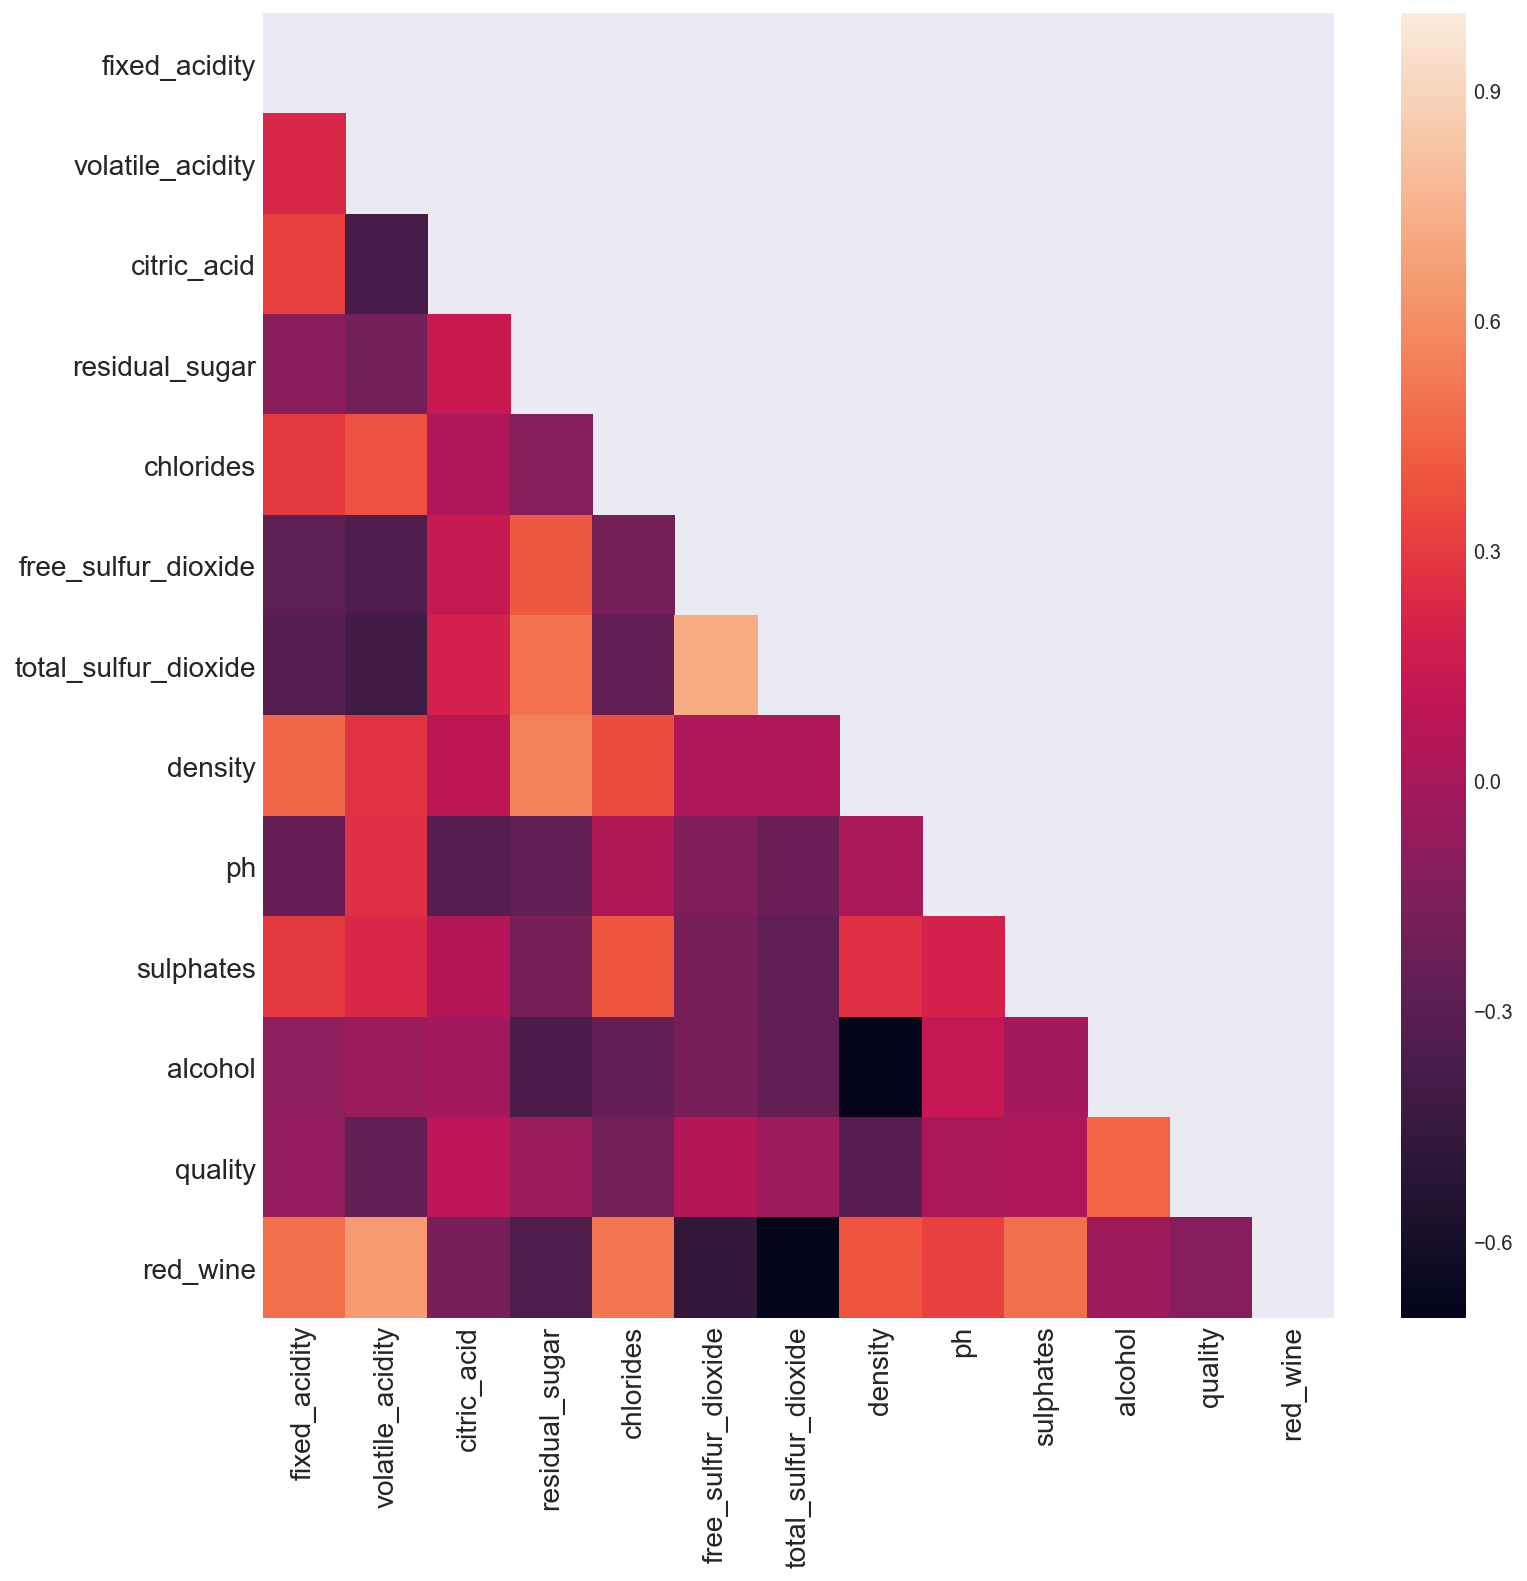

In [9]:
fix, ax = plt.subplots(figsize=(12,12))

mask = np.zeros_like(wine.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(wine.corr(), mask=mask, ax=ax)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14);

### Create the target and predictor matrix 

Our goal today is to show you how regularization can prevent overfitting. We are going to create a very complex dataset that will overfit to our data.

#### With sklearn

In [10]:
not_quality = [x for x in wine.columns if x != 'quality']

In [11]:
from sklearn.preprocessing import PolynomialFeatures

X = wine[not_quality]
y = wine['quality']

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

Xoverfit = poly.fit_transform(X)

In [12]:
poly.get_feature_names(X.columns)

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'ph',
 'sulphates',
 'alcohol',
 'red_wine',
 'fixed_acidity^2',
 'fixed_acidity volatile_acidity',
 'fixed_acidity citric_acid',
 'fixed_acidity residual_sugar',
 'fixed_acidity chlorides',
 'fixed_acidity free_sulfur_dioxide',
 'fixed_acidity total_sulfur_dioxide',
 'fixed_acidity density',
 'fixed_acidity ph',
 'fixed_acidity sulphates',
 'fixed_acidity alcohol',
 'fixed_acidity red_wine',
 'volatile_acidity^2',
 'volatile_acidity citric_acid',
 'volatile_acidity residual_sugar',
 'volatile_acidity chlorides',
 'volatile_acidity free_sulfur_dioxide',
 'volatile_acidity total_sulfur_dioxide',
 'volatile_acidity density',
 'volatile_acidity ph',
 'volatile_acidity sulphates',
 'volatile_acidity alcohol',
 'volatile_acidity red_wine',
 'citric_acid^2',
 'citric_acid residual_sugar',
 'citric_acid chlorides',
 'citric_acid free_sulfur_diox

In [13]:
Xoverfit.shape

(6497, 90)

#### Let's split our data up into training and testing sets. Why do we split our data into training and testing sets?

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_overfit_train, X_overfit_test, y_overfit_train, y_overfit_test = train_test_split(Xoverfit,
                                                                                    y,
                                                                                    test_size = 0.33,
                                                                                    random_state = 42)

In [16]:
print(f'X_overfit_train shape is: {X_overfit_train.shape}')
print(f'y_overfit_train shape is: {y_overfit_train.shape}')
print(f'X_overfit_test shape is: {X_overfit_test.shape}')
print(f'y_overfit_test shape is: {y_overfit_test.shape}')

X_overfit_train shape is: (4352, 90)
y_overfit_train shape is: (4352,)
X_overfit_test shape is: (2145, 90)
y_overfit_test shape is: (2145,)


<a id='standardization'></a>

## Standardizing predictors is required

---

When regularizing, **it is neccessary to standardize the predictor columns before constructing the models, even the dummy coded categorical variables**.

Below we define our target variable, then normalize the columns that are not the target.

We are going to change our loss function to add a penalty. The equations for the Ridge and Lasso penalties:

### $$ \text{Ridge penalty}\; = \alpha \sum_{j=1}^p \beta_j^2$$

### $$ \text{Lasso penalty}\; = \alpha \sum_{j=1}^p |\beta_j|$$

<details><summary>Why might I need to standardize my variables before regularizing?</summary>
    
- Regularization penalizes the magnitude (size) of the coefficients.
- The size of the coefficient depends on the scale of the independent (X) variable.
- Suppose I wanted to predict one's income using their high school GPA and the square footage of their childhood home as predictors. 
$$
\begin{eqnarray*}
\text{income} &=& \beta_0 + \beta_1\text{GPA} + \beta_2\text{sqft}
\end{eqnarray*}
$$
</details>

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
ss_overfit = StandardScaler()

Z_overfit_train = pd.DataFrame(ss_overfit.fit_transform(X_overfit_train))

In [19]:
Z_overfit_train.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,-0.075168,-1.336968,0.000859,0.862292,-0.045023,1.920234,0.833669,0.505082,1.141711,-0.817594,...,1.137245,-0.635999,-0.412164,-0.560298,-0.689987,-1.011649,-0.540347,-0.887016,-0.557374,-0.561074
1,-0.309280,-1.336968,-0.137534,1.550281,-0.194369,0.087320,-0.492591,0.617704,-0.110015,-1.230159,...,-0.133139,-1.193370,-0.476628,-0.560298,-0.926929,-1.244385,-0.540347,-0.514229,-0.557374,-0.561074
2,0.393055,0.271545,0.554427,-0.722166,-0.522929,-0.141795,0.654444,-1.349867,-0.235188,-1.436442,...,-0.255942,-1.401672,1.674179,-0.560298,-1.031370,-0.847716,-0.540347,2.128119,-0.557374,-0.561074
3,1.095391,0.952069,-0.275926,-0.743014,1.627646,-0.600023,0.367686,0.836323,-1.799846,9.771580,...,-1.726026,8.150732,-1.092033,1.511167,18.194676,8.232610,6.147708,-0.514229,1.656757,1.782297
4,-0.855541,-0.842041,-1.037082,-0.805559,-0.224238,0.889220,0.242229,-1.217371,0.515848,-0.680072,...,0.492429,-0.585144,0.890937,-0.560298,-0.602693,-0.384635,-0.540347,0.720026,-0.557374,-0.561074


<a id='viz-ridge'></a>

## Defining and Visualizing the Ridge

---

### $$ \text{minimize:}\; SSE+Ridge = \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2 + \alpha\sum_{j=1}^p \beta_j^2$$

**Where:**

$\beta_j^2$ is the squared coefficient for variable $x_j$.

$\sum_{j=1}^n \beta_j^2$ is the sum of these squared coefficients for every variable in the model. 
- This does **not** include the intercept $\beta_0$.

$\alpha$ is a constant for the _strength_ of the regularization parameter. The higher the value, the greater the impact of this new component in the loss function. If the value was zero, we would revert back to just the least squares loss function. If the value was a billion, however, the residual sum of squares component would have a much smaller effect on the loss/cost than the regularization term.

Now all **you** have to do is...

In [20]:
from sklearn.linear_model import Ridge

This function iterates over a series of different alpha regularization parameters and stores the results of the model so that we can plot them interactively.

> This will not be part of your typical workflow.  This for learning purposes only!

**Alpha values for the Ridge are best visualized on a logarithmic "magnitude" scale.** Essentially, the effect of alpha on the coefficients does not increase linearly but by orders of magnitude. 

In [21]:
def ridge_coefs(X, y, alphas):
    
    coefs = []
    
    ridge_reg = Ridge()
    
    for a in alphas:
        
        ridge_reg.set_params(alpha=a)
        
        ridge_reg.fit(X, y)
        
        coefs.append(ridge_reg.coef_)
        
    return coefs

r_alphas = np.logspace(0, 5, 100)

r_coefs = ridge_coefs(X, y, r_alphas)


from cycler import cycler

def coef_plotter(alphas, coefs, feature_names, to_alpha, regtype='ridge'):
    
    amin = np.min(alphas)
    amax = np.max(alphas)
    
    alphas = [a for a in alphas if a <= to_alpha]
    coefs = coefs[0:len(alphas)]
    
    colors = sns.color_palette("husl", len(coefs[0]))

    fig = plt.figure()
    fig.set_size_inches(18,5)

    ax1 = fig.add_subplot(121)

    ax1.set_prop_cycle(cycler('color', colors))

    ax1.axvline(to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)

    ax1.plot(alphas, coefs, lw=2)

    ax1.set_xlabel('alpha', fontsize=20)
    ax1.set_ylabel('coefficients', fontsize=20)

    if regtype == 'ridge':
        ax1.set_xscale('log')

    ax1.set_xlim([amin, amax])

    ax1.set_title(regtype+' coef paths\n', fontsize=20)

    ymin, ymax = ax1.get_ylim()

    ax2 = fig.add_subplot(122)

    ax2.bar(list(range(1, len(feature_names)+1)), coefs[-1], align='center', color=colors)
    ax2.set_xticks(list(range(1, len(feature_names)+1)))

    ax2.set_xticklabels(feature_names, rotation=65, fontsize=12)

    ax2.set_ylim([ymin, ymax])
    ax2.set_title(regtype+' predictor coefs\n', fontsize=20)
    ax2.set_ylabel('coefficients', fontsize=20)
    
    plt.show();

The plotting function above will:

 - Plot the effect of changing alpha on the coefficient size on a **path** graph
 - Plot the effect of changing alpha on the coefficient size on a **bar** graph
 
Each one gives information. It's just two different ways of visualizing the same thing. The chart is interactive so you can play around with the values of alpha across the specified range above.

The function and `interact` from ipywidgets allows us to take some specified alphas that we have already calculated the coefficients for and plot them out in an interactive way.

In [22]:
from ipywidgets import *
from IPython.display import display

def ridge_plot_runner(log_of_alpha=0):
    coef_plotter(r_alphas, r_coefs, X.columns, 10**log_of_alpha, regtype='ridge')

interact(ridge_plot_runner, log_of_alpha=(0.1,5,0.2))

interactive(children=(FloatSlider(value=0.1, description='log_of_alpha', max=5.0, min=0.1, step=0.2), Output()), _dom_classes=('widget-interact',))

<function __main__.ridge_plot_runner>

<a id='viz-lasso'></a>

## Defining and Visualizing the Lasso

---

Now we do the same thing as above but for the Lasso.

Lasso regression takes a different approach. Instead of adding the sum of squared $\beta$ coefficients to the SSE, it adds the sum of the absolute values of the $\beta$ coefficients:

### $$ \text{minimize:}\; SSE + Lasso = \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2 + \alpha\sum_{j=1}^p |\beta_j|$$

**Where:**

$|\beta_j|$ is the absolute value of the $\beta$ coefficient for variable $x_j$.

$\alpha$ is again the strength of the regularization penalty component in the loss function. 

In [23]:
from sklearn.linear_model import Lasso

In [24]:
def lasso_coefs(X, y, alphas):
    coefs = []
    lasso_reg = Lasso()
    for a in alphas:
        lasso_reg.set_params(alpha=a)
        lasso_reg.fit(X, y)
        coefs.append(lasso_reg.coef_)
    return coefs

**Alpha values for the LASSO are best visualized on a linear scale.**

In [25]:
l_alphas = np.linspace(0.001, 0.15, 100)
l_coefs = lasso_coefs(X, y, l_alphas)

Run the same plotting function above, but now with the calculated coefficients of alpha for the Lasso.

In [26]:
def lasso_plot_runner(alpha=0):
    coef_plotter(l_alphas, l_coefs, X.columns, alpha, regtype='lasso')

interact(lasso_plot_runner, alpha=(0.001,0.2,0.01))

interactive(children=(FloatSlider(value=0.001, description='alpha', max=0.2, min=0.001, step=0.01), Output()), _dom_classes=('widget-interact',))

<function __main__.lasso_plot_runner>

<a id='model-performance'></a>

## Model performance of the Ridge and LASSO on the overfit data

### (i.e., what do I actually need to do?)

---

Let's check out how the penalties affect the performance of our models. Let's use the overfit data instead to see if regularization helps us control overfitting.

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

**Let's start with plain vanilla linear regression:**

In [28]:
model = LinearRegression()

In [29]:
model.fit(X_overfit_train, y_overfit_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
y_overfit_hat = model.predict(X_overfit_test)

In [31]:
r2_score(y_overfit_test, y_overfit_hat)

0.29662257128676295

<details><summary>How do we interpret this $R^2$ score?</summary>
29.7% of the variability in our $Y$ (wine quality) is explained by our model, relative to a baseline model with no predictors.
</details>

In [32]:
lr_preds_train = model.predict(X_overfit_train)
r2_score(y_overfit_train, lr_preds_train)

0.3765796406731149

<details><summary>Given these two R2 scores together, what do you conclude?</summary>
Because our training performance is better than our testing performance, it's likely that our model is overfit (and thus too complex). We should consider regularizing.
</details>

### Ridge Regression

**Now let's make it into a Ridge regression by adding the penalty term:**

In [33]:
ridge_model = Ridge(alpha=10)

ridge_model.fit(X_overfit_train, y_overfit_train)

ridge_preds = ridge_model.predict(X_overfit_test)
ridge_preds_train = ridge_model.predict(X_overfit_train)

print(r2_score(y_overfit_test, ridge_preds))
print(r2_score(y_overfit_train, ridge_preds_train))

0.26686206833016624
0.3518305655449936


Which $\alpha$ to choose?  Let's search! (Remember that we search logarithmic space for Ridge regularization.)

In [34]:
from sklearn.linear_model import RidgeCV

In [35]:
r_alphas = np.logspace(0, 5, 100)

ridge_model = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

ridge_model = ridge_model.fit(X_overfit_train, y_overfit_train)

In [36]:
ridge_optimal_alpha = ridge_model.alpha_
ridge_optimal_alpha

1353.0477745798062

Let's get the corresponding value of $R^2$.

In [37]:
ridge_opt = Ridge(alpha=ridge_optimal_alpha)

ridge_opt.fit(X_overfit_train, y_overfit_train)

ridge_opt_preds = ridge_opt.predict(X_overfit_test)
ridge_opt_preds_train = ridge_opt.predict(X_overfit_train)

print(r2_score(y_overfit_test, ridge_opt_preds))
print(r2_score(y_overfit_train, ridge_opt_preds_train))

0.2519222524965333
0.3360082028211897


### Lasso Regression

In [38]:
from sklearn.linear_model import LassoCV

In [39]:
l_alphas = np.linspace(0.15, 1, 85)

lasso_model = LassoCV(alphas=l_alphas, cv=5)

lasso_model = lasso_model.fit(X_overfit_train, y_overfit_train)

In [40]:
lasso_optimal_alpha = lasso_model.alpha_
lasso_optimal_alpha

0.15

In [41]:
lasso_model_preds = lasso_model.predict(X_overfit_test)
lasso_model_preds_train = lasso_model.predict(X_overfit_train)

print(r2_score(y_overfit_test, lasso_model_preds))
print(r2_score(y_overfit_train, lasso_model_preds_train))

0.25681288536291147
0.3022259523318307


### Let's check out the coefficients of the Lasso and Ridge models.

In [42]:
ridge_model.coef_

array([ 6.27092339e-03, -5.83298210e-03,  7.99041558e-04,  1.08111233e-02,
       -5.99584591e-04,  1.73606058e-03,  7.52141285e-03, -7.79679166e-05,
       -9.41131264e-04,  5.14916751e-03, -3.07413425e-03,  1.61548866e-03,
       -1.11942923e-03, -3.47114700e-02, -1.04147415e-02,  1.23984348e-02,
       -4.59080891e-03,  1.94996278e-03, -8.16793015e-04,  5.71486044e-03,
        1.87836537e-02,  4.38873198e-02, -9.28003278e-03,  3.33476240e-02,
       -3.73126819e-03, -3.49142050e-04, -2.80354974e-02, -5.23613645e-04,
        4.62467248e-03, -5.46144149e-03, -5.83494007e-03, -2.04633711e-02,
       -6.35101010e-04, -4.48754263e-02,  6.73916654e-04, -3.17769223e-03,
       -1.83118564e-02, -4.77615356e-04, -8.84766353e-04,  1.30952449e-04,
        7.43158649e-04,  3.94955488e-03,  4.17794034e-04,  1.14128542e-02,
       -1.67870710e-03, -2.28113138e-04,  1.22275070e-03, -5.62631596e-04,
        2.07386698e-04,  1.10757231e-02, -2.92815086e-02,  1.04738416e-03,
        1.68998271e-03, -

In [43]:
lasso_model.coef_

array([ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.64598425e-03, -0.00000000e+00,  0.00000000e+00,  2.08401302e-03,
       -0.00000000e+00,  0.00000000e+00, -4.17678693e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -1.15945468e-02, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.85502728e-04, -0.00000000e+00, -3.23714385e-04,
        2.03805862e-04,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  

## Important Notes
- The $\alpha$ hyperparameter for regularization is **unrelated** to significance level in hypothesis testing.
- In certain resources, including [ISLR](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), you'll see that $\lambda$ is used instead of $\alpha$ for regularization strength.
- We must standardize before regularizing, but regularization and standardization are not the same things!

## Recap
- Regularization is used when evidence suggests our model is suffering from high error due to variance.
- Evidence to suggest our model suffers from high error due to variance includes substantially better performance on our training set than our testing set.
- LASSO tends to be "more brutal" than Ridge regularization in that it will zero out coefficients.
- If you want to combine LASSO and Ridge regularization, there is a technique called "ElasticNet" that does exactly this.

## ElasticNet Regression (bonus)

---

Can't decide?  Buy both!!

The Elastic Net combines the Ridge and Lasso penalties.  It adds *both* penalties to the loss function:

### $$ \text{minimize:}\; SSE + Ridge + Lasso = \sum_{i=1}^n \left(y_i - \hat{y}_i\right)^2 + \alpha\left[\rho\sum_{j=1}^p |\beta_j| + (1-\rho)\sum_{j=1}^p \beta_j^2\right]$$

In the elastic net, the effect of the ridge versus the lasso is balanced by the $\rho$ parameter.  It is the ratio of Lasso penalty to Ridge penalty and must be between zero and one.

`ElasticNet` in sklearn has two parameters:
- `alpha`: the regularization strength.
- `l1_ratio`: the amount of L1 vs L2 penalty (i.e., $\rho$). An l1_ratio of 0 is equivalent to the Ridge, whereas an l1_ratio of 1 is equivalent to the Lasso.


In [44]:
from sklearn.linear_model import ElasticNet

Calculate the coefficients with both alpha values and an l1_ratio of 0.05. Lasso can "overpower" the Ridge penalty in some datasets, and so rather than an equal balance I'm just adding a little bit of Lasso in.
- Using a $\rho$ value below 0.05 can empirically cause issues in `sklearn`.

In [45]:
def elasticnet_coefs(X, y, alphas):
    coefs = []
    enet_reg = ElasticNet()
    for a in alphas:
        enet_reg.set_params(alpha=a, l1_ratio=0.05)
        enet_reg.fit(X, y)
        coefs.append(enet_reg.coef_)
        
    return coefs

In [46]:
enet_alphas = np.linspace(0.01, 1.0, 200)
enet_coefs = elasticnet_coefs(X, y, enet_alphas)

In [47]:
def enet_plot_runner(alpha=0.01):
    coef_plotter(enet_alphas, enet_coefs, X.columns, alpha, regtype='elastic net')

interact(enet_plot_runner, alpha=(0.0,1.0,0.005))

interactive(children=(FloatSlider(value=0.01, description='alpha', max=1.0, step=0.005), Output()), _dom_classes=('widget-interact',))

<function __main__.enet_plot_runner>

In [48]:
from sklearn.linear_model import ElasticNetCV

In [49]:
enet_alphas = np.linspace(0.5, 1.0, 100)

enet_ratio = 0.5

enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5)

enet_model = enet_model.fit(X_overfit_train, y_overfit_train)

enet_model_preds = enet_model.predict(X_overfit_test)
enet_model_preds_train = enet_model.predict(X_overfit_train)

print(r2_score(y_overfit_test, enet_model_preds))
print(r2_score(y_overfit_train, enet_model_preds_train))

0.25528537799934936
0.2993246370138991


In [50]:
enet_optimal_alpha = enet_model.alpha_
enet_optimal_alpha

0.5